In [1]:
import cv2
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import chainercv
from chainercv.datasets import VOCSemanticSegmentationDataset
from chainer.datasets import TransformDataset
from chainercv.evaluations import eval_semantic_segmentation
import os.path
from os import path
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import random
import glob
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import copy
use_cuda = torch.cuda.is_available()
device =  torch.device("cuda" if use_cuda else "cpu")
from PIL import Image
import torch.utils.data as data
from torch.utils.data import DataLoader

## Create Dataset

In [25]:
class DataLoaderSegmentation(data.Dataset):
        def __init__(self, split):
            super(DataLoaderSegmentation, self).__init__()
        
            if split not in ['train', 'val', 'test']:
                raise ValueError('please pick split from \'train\', \'test\', or \'val\'')
            
            dir_path = os.getcwd()
            self.split = split
            self.image_paths = os.path.join(dir_path, 'data', 'tas500v1.1', 'tas500v1.1', split)
            if self.split != 'test':
                self.label_paths = os.path.join(dir_path, 'data', 'tas500v1.1', 'tas500v1.1', split + '_labels_ids')
                self.labels = os.listdir(self.label_paths)
            self.files = os.listdir(self.image_paths)
            
        def __len__(self):
            return len(self.files)
        
        def __getitem__(self, idx):
            image_name = self.files[idx]
            
            image = Image.open(os.path.join(self.image_paths, image_name)).convert('RGB')

            if self.split != 'test':
                label_name = self.labels[idx]
                mask  = Image.open(os.path.join(self.label_paths, label_name))
                x, y = self.transformData(image, mask)
                y = np.where(y == 255, 23, y)
                x, y = torch.from_numpy(x).float(), torch.from_numpy(y).long()
                x = torch.permute(x, (2, 0, 1))
                return x, y
            else:
                x, y = self.transformData(image, None)
                x = torch.from_numpy(x).float()
                x = torch.permute(x, (2, 0, 1))
                return x
    
        def transformData(self, image, mask=None):
            # Random crop
            i, j, h, w = transforms.RandomCrop.get_params(
                image, output_size=(512,512))
            image = TF.crop(image, i, j, h, w)
            if mask is not None:
                mask = TF.crop(mask, i, j, h, w)

            # Random horizontal flip
            if random.random() > 0.5:
                image = TF.hflip(image)
                if mask is not None:
                    mask = TF.hflip(mask)

            # Random Vertical Flip
            if random.random() > 0.5:
                image = TF.vflip(image)
                if mask is not None:
                    mask = TF.vflip(mask)

            image = np.array(image)
            if mask is not None:
                mask  = np.array(mask)
            
            image = image[:, :, ::-1].copy()
            
            return image, mask

In [4]:
train_data = DataLoaderSegmentation('train')

In [5]:
def find_image():
    trunk_label = 10
    bush_label = 4
    person_label = 20
    animal_label = 21
    count = 0
    max_count = 3
    for i in range(len(train_data)):
        tmp_count = np.unique(train_data[i][1], return_counts=True)
#         print(tmp_count)
        if person_label in tmp_count[0]:
#             if tmp_count[1][i] > 100
            if count == max_count:
                break
            else:
                img, label = train_data[i]
                fig = plt.figure(figsize=(4,3))
                ax = fig.add_subplot(1,1,1)
                plt.title('Image ' + str(i))
                ax.imshow(np.rollaxis(img.numpy().astype(int), 0, 0))
                count += 1

# find_image()

palette = [0, 0, 0, 128, 0, 0, 0, 128, 0, 128, 128, 0, 0, 0, 128, 128, 0, 128, 0, 128, 128,
           128, 128, 128, 64, 0, 0, 192, 0, 0, 64, 128, 0, 192, 128, 0, 64, 0, 128, 192, 0, 128,
           64, 128, 128, 192, 128, 128, 0, 64, 0, 128, 64, 0, 0, 192, 0, 128, 192, 0, 0, 64, 128]

# Some relevant images
img_113, seg_img_113 = train_data[113]
img_28, seg_img_28 = train_data[28]
img_354, seg_img_354 = train_data[354]

def colorize_mask(mask):
    new_mask = Image.fromarray(mask.numpy().astype(np.uint8)).convert('P')
    new_mask.putpalette(palette)
                      
    return new_mask

def add_img_plot(fig, index, img, title, sub_plot_id):
    ax = fig.add_subplot(sub_plot_id[0],sub_plot_id[1],sub_plot_id[2])
    plt.title(title + str(index))
    ax.imshow(img)

    
fig = plt.figure(figsize=(10,10))

# person image
add_img_plot(fig, 113, np.rollaxis(img_113.numpy().astype(int), 0, 3), 'Image ', [3,2,1])
add_img_plot(fig, 113, colorize_mask(seg_img_113), 'Segmented Image ', [3,2,2])
# car image
add_img_plot(fig, 28, np.rollaxis(img_28.numpy().astype(int), 0, 3), 'Image ', [3,2,3])
add_img_plot(fig, 28, colorize_mask(seg_img_28), 'Segmented Image ', [3,2,4])
# animal image
add_img_plot(fig, 354, np.rollaxis(img_354.numpy().astype(int), 0, 3), 'Image ', [3,2,5])
add_img_plot(fig, 354, colorize_mask(seg_img_354), 'Segmented Image ', [3,2,6])

In [6]:
if device == 'cpu':
    train_loader = DataLoader(train_data, batch_size=5, shuffle=True, num_workers=0)
else:
    train_loader = DataLoader(train_data, batch_size=8, shuffle=True, num_workers=0)

In [39]:
class Net(nn.Module):
    def __init__(self, criterion=None):
        super(Net, self).__init__()
        self.criterion = criterion        
        self.mobilenet_v2 = models.mobilenet_v2(pretrained=True)
        self.conv1 = nn.Conv2d(1280, 64, 3, 1)
        self.conv2 = nn.Conv2d(64, 24, 3, 1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(24)
        self.dropout1 = nn.Dropout2d()
    def forward(self, inp, gts=None): 
        output_size = (inp.size()[2],inp.size()[3])
#         print('input')
#         print(inp.shape)
        # Encoder
        x = self.mobilenet_v2.features(inp)
        x = F.interpolate(x, size=(32, 32))
        # Decoder Layer 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = F.interpolate(x, size=(output_size[0] + 2, output_size[1] + 2))
#         print('decoder layer 1 output')
#         print(x.shape)
        
        # Decoder Layer 2
        x = self.conv2(x)
        lfinal = self.bn2(x)
        
#         print('final')
#         print(lfinal.shape)
        if self.training:
            # Return the loss if in training mode
            return self.criterion(lfinal, gts)
        else:
            # Return the actual prediction otherwise
            return lfinal

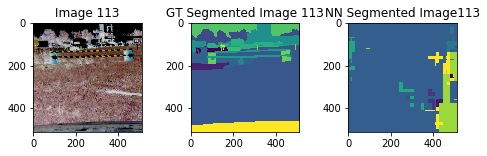

In [40]:
torch.cuda.empty_cache()
def colorize_mask_nn_output(mask):
    new_mask = Image.fromarray(mask.astype(np.uint8)).convert('P')
    new_mask.putpalette(palette)
                      
    return new_mask


untrained_net = Net().to(device)
untrained_net.eval()

sample_img, sample_target = train_data[113]

untrained_output = untrained_net.forward(sample_img[None].to(device))
if device != 'cpu':
    untrained_output = untrained_output.cpu()
untrained_nn_seg_img_113 = torch.argmax(untrained_output.cpu(), dim=1).numpy()[0]

fig = plt.figure(figsize=(8,2))
add_img_plot(fig, 113, transforms.ToPILImage()(img_113), 'Image ', [1,3,1])
add_img_plot(fig, 113, colorize_mask(seg_img_113), 'GT Segmented Image ', [1,3,2])
add_img_plot(fig, 113, colorize_mask_nn_output(untrained_nn_seg_img_113), 'NN Segmented Image', [1,3,3])

In [9]:
def train(train_loader, net, optimizer, loss_graph, device):
    for batch_idx, (data, target) in enumerate(train_loader):
        img, gt_seg_img = data.to(device), target.to(device)
        # This is a forward pass which also returns loss due to training mode    
        main_loss = net(img, gts=gt_seg_img)
        
        # Populate this list to graph the loss
        loss_graph.append(main_loss.item())
        
        # View the loss within the epoch
        print(main_loss.item())
        
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        main_loss.backward()
        optimizer.step()
        
    return main_loss

In [10]:
def get_optimizer(net):
    optimizer = torch.optim.SGD(net.parameters(),
                               lr=0.1,
                               weight_decay=1e-5,
                               momentum=0.5,
                               nesterov=False)
    return optimizer

Starting Training...
3.6491708755493164
3.312981605529785
3.0108695030212402
2.857584238052368
2.820251226425171
2.752448081970215
2.631051778793335
2.6674914360046387
2.522329330444336
2.3917622566223145
2.483879566192627
2.261409282684326
2.2847559452056885
2.3963725566864014
2.244211196899414
2.1502630710601807
2.2890658378601074
2.198277235031128
2.156747341156006
1.9565950632095337
2.2101125717163086
2.1976985931396484
1.9872323274612427
1.9064509868621826
1.801537036895752
1.827610969543457
1.9314155578613281
2.140371322631836
1.7641512155532837
1.695389986038208
2.010103702545166
1.945991039276123
1.7751479148864746
2.03739857673645
1.6507171392440796
2.0970258712768555
2.208064317703247
1.9580368995666504
1.5616222620010376
2.150824785232544
1.994422435760498
2.0573644638061523
2.245176076889038
2.109314441680908
2.1272292137145996
1.905410885810852
2.0214943885803223
1.8578540086746216
1.6719061136245728
1.4410781860351562
2.071471691131592
1.8191663026809692
1.851759076118469

1.2115849256515503
1.0052052736282349
1.3190408945083618
1.459180235862732
1.1230013370513916
1.249692440032959
1.0710713863372803
0.7696754336357117
1.1671254634857178
0.83448326587677
1.301548719406128
1.6531367301940918
0.8413415551185608
0.9616524577140808
1.2954505681991577
1.2126696109771729
Epoch: 7 Loss: 1.2126696109771729
0.9775866270065308
0.9583660960197449
0.9991856217384338
1.07949697971344
1.2268978357315063
1.3820229768753052
1.1036537885665894
1.2589807510375977
1.0829488039016724
1.0323652029037476
0.9292857050895691
0.912371814250946
0.9884570837020874
0.9072207808494568
1.1250311136245728
0.8981388211250305
1.3510620594024658
1.0962932109832764
0.7767917513847351
1.0596343278884888
1.0653679370880127
1.1945613622665405
0.9286110997200012
1.1369397640228271
1.32183039188385
1.0847359895706177
1.4787817001342773
0.9206855297088623
1.7900654077529907
1.1178321838378906
1.0024241209030151
1.0529166460037231
1.2460037469863892
1.1513819694519043
1.0147430896759033
0.84704

0.9670237302780151
0.783812403678894
0.9794802069664001
1.1956944465637207
0.9628080129623413
1.0829224586486816
0.8640254139900208
1.0268126726150513
1.110979676246643
1.0120840072631836
0.9384369254112244
0.9308000206947327
0.8079363703727722
0.9095701575279236
0.72746342420578
1.1887308359146118
0.748317539691925
0.8605005741119385
0.818601131439209
1.0831530094146729
1.2960078716278076
0.9140821099281311
0.7262455821037292
1.110720157623291
0.9537157416343689
0.9805729985237122
0.9469613432884216
0.9323857426643372
0.8232475519180298
0.7963212132453918
0.6670050621032715
1.14711594581604
0.7561831474304199
1.1190038919448853
Epoch: 15 Loss: 1.1190038919448853
0.8926246166229248
1.1388505697250366
0.9814441204071045
0.86283940076828
1.4919710159301758
1.1648718118667603
1.057694435119629
1.022060513496399
0.9387481808662415
1.4081133604049683
0.9598075151443481
0.8984584808349609
1.2073800563812256
1.2481212615966797
1.2781580686569214
0.9230614900588989
0.958808958530426
0.93405884

0.7983298301696777
1.2107232809066772
1.1339913606643677
1.0876429080963135
0.7952088117599487
0.8385802507400513
1.1260312795639038
1.1295323371887207
0.6263443231582642
0.880831778049469
1.2350434064865112
1.0845553874969482
1.3155317306518555
0.6421226263046265
1.20779550075531
0.9576491117477417
1.0282869338989258
0.9360677599906921
0.7845237851142883
0.9648157954216003
1.2046574354171753
0.7307323217391968
1.0578923225402832
1.1415735483169556
1.053990364074707
0.9196599125862122
1.0763646364212036
0.7583286762237549
0.8929800391197205
0.6111741065979004
1.118908166885376
1.028951644897461
1.1757490634918213
1.1355762481689453
0.9664645791053772
0.9076225757598877
0.7646617889404297
1.0098568201065063
1.0912744998931885
0.733055055141449
1.263443112373352
0.7934382557868958
0.9794750213623047
0.92424476146698
0.8391660451889038
0.8059394955635071
0.8072678446769714
0.8741313815116882
0.8033886551856995
0.8329489827156067
0.711449384689331
1.4638779163360596
0.9581143856048584
1.01

1.031830906867981
0.8686363697052002
1.0967494249343872
1.0022348165512085
0.8606653809547424
0.7379130721092224
0.6393661499023438
0.8506254553794861
1.1480035781860352
0.9728199243545532
0.7884618043899536
0.8082489967346191
0.5940589904785156
1.009917140007019
0.753690242767334
0.9526549577713013
0.618804931640625
Epoch: 30 Loss: 0.618804931640625
1.0852794647216797
1.42788565158844
1.0067682266235352
0.9071203470230103
0.7116104364395142
0.8565037846565247
0.9864602088928223
1.024153470993042
0.8029303550720215
0.6862473487854004
0.6653982996940613
0.7743498086929321
1.0950690507888794
0.5842849612236023
0.6475099325180054
0.9704997539520264
1.0532166957855225
0.5611416697502136
0.9367331862449646
0.6919657588005066
1.0104618072509766
0.9209122061729431
0.955937385559082
0.7009090781211853
1.243029236793518
0.8710366487503052
1.19148588180542
0.7632877230644226
0.9503820538520813
0.8557136654853821
1.0545891523361206
1.0727301836013794
0.8377866148948669
0.6949764490127563
0.776486

0.8721281290054321
0.5348477363586426
0.7781121730804443
1.1111876964569092
0.7371408343315125
0.8862311244010925
0.789594829082489
0.9947859048843384
0.43290820717811584
1.2507460117340088
0.8069884181022644
0.7675988078117371
0.9325149059295654
0.9910179972648621
1.2898882627487183
0.6610210537910461
0.7570282220840454
0.9747440218925476
0.7712129950523376
0.7336832880973816
0.66989666223526
0.8529304265975952
0.9836306571960449
0.6932319402694702
0.7886634469032288
0.684251606464386
1.2950983047485352
0.9948540925979614
0.5247852206230164
1.106695532798767
0.9116590023040771
0.7099258303642273
0.958734929561615
0.8026064038276672
0.693572998046875
0.9730262756347656
Epoch: 38 Loss: 0.9730262756347656
0.986463189125061
0.7758139371871948
0.7269973754882812
0.6023886799812317
0.8487851619720459
0.7459671497344971
0.8956063389778137
0.8038862943649292
0.7416994571685791
0.955298662185669
0.7723944783210754
0.803830623626709
0.7468802332878113
0.8838700652122498
0.8133940696716309
0.715

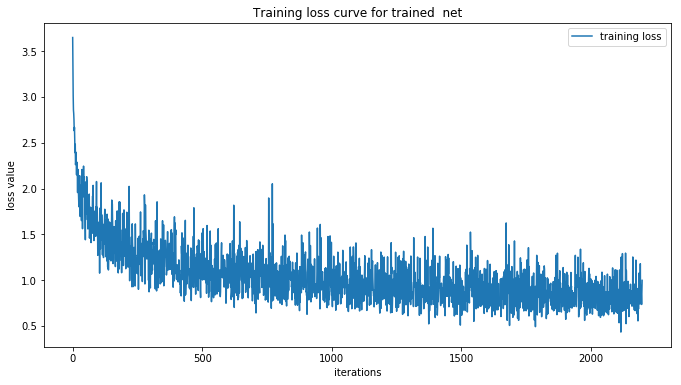

In [11]:
%%time
%matplotlib inline

# Deep copy in order to train the network with the same initialized weights
trained_net = copy.deepcopy(untrained_net)
trained_net = trained_net.to(device)

# set loss function for the net
trained_net.criterion = nn.CrossEntropyLoss(ignore_index=-1)
# You can change the number of EPOCHS
EPOCH = 40

# switch to train mode (original untrained_net was set to eval mode)
trained_net.train()

optimizer = get_optimizer(trained_net)

print("Starting Training...")

loss_graph = []

fig = plt.figure(figsize=(12,6))
plt.subplots_adjust(bottom=0.2,right=0.85,top=0.95)
ax = fig.add_subplot(1,1,1)

for e in range(EPOCH):
    loss = train(train_loader, trained_net, optimizer, loss_graph, device)
    ax.clear()
    ax.set_xlabel('iterations')
    ax.set_ylabel('loss value')
    ax.set_title('Training loss curve for trained  net')
    ax.plot(loss_graph, label='training loss')
    ax.legend(loc='upper right')
    fig.canvas.draw()
    print("Epoch: {} Loss: {}".format(e, loss))

In [12]:
def validate(val_loader, net):
    iou_arr = []
    val_loss = 0
    
    net.eval()
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            img, gt_seg_img = data.to(device), target.to(device)
            
            output = net(img)
            
            if device != 'cpu':
                output = output.cpu()
                gt_seg_img = gt_seg_img.cpu()
            pred = torch.argmax(output, dim=1).numpy()[0]
            
            gt_np = gt_seg_img.numpy()[0]
            
            conf = eval_semantic_segmentation(pred[None], gt_np[None])
            
            iou_arr.append(conf['miou'])
            
    return val_loss, (sum(iou_arr) / len(iou_arr))

In [13]:
val_data = DataLoaderSegmentation('val')
val_loader = DataLoader(val_data, batch_size=1, shuffle=True, num_workers=0)

In [14]:
%%time
print("mIoU over the training dataset:{}".format(validate(train_loader, trained_net)[1]))

C:\Users\Jack Capombassis\miniconda3\envs\carnd-term1\lib\site-packages\chainercv\evaluations\eval_semantic_segmentation.py:91: RuntimeWarning: invalid value encountered in true_divide
  iou = np.diag(confusion) / iou_denominator
C:\Users\Jack Capombassis\miniconda3\envs\carnd-term1\lib\site-packages\chainercv\evaluations\eval_semantic_segmentation.py:168: RuntimeWarning: invalid value encountered in true_divide
  class_accuracy = np.diag(confusion) / np.sum(confusion, axis=1)


mIoU over the training dataset:0.4073248580648385
Wall time: 57.6 s


In [15]:
%%time
print("mIoU over the validation dataset:{}".format(validate(val_loader, trained_net)[1]))

mIoU over the validation dataset:0.39125303099685305
Wall time: 17.2 s


View count of pixels within each label category:
(array([ 4,  5,  6,  7,  9, 10, 11, 12, 16, 18, 20, 22], dtype=int64), array([  1833,   3036, 129505,  67122,    188,    218,   8939,   1005,
         2027,    523,  21914,  25834], dtype=int64))
(array([ 5,  6,  7, 20, 22], dtype=int64), array([  2627, 134435,  78675,  25566,  20841], dtype=int64))
View count of pixels within each label category:
(array([ 0,  4,  5,  6,  7,  8,  9, 10, 11, 14, 16, 22], dtype=int64), array([ 44876,    799,  15670,  11709,  26467,   6848,  11507,   1034,
          260, 126409,   1874,  14691], dtype=int64))
(array([ 0,  5,  6,  7,  8, 14, 22], dtype=int64), array([ 45565,  34710,  25535,   6731,   2590, 133999,  13014],
      dtype=int64))
View count of pixels within each label category:
(array([ 1,  5,  6, 12, 16], dtype=int64), array([ 17972,    671,  69414, 148475,  25612], dtype=int64))
(array([ 1,  6,  7,  9, 11, 12, 16], dtype=int64), array([ 13211,  61724,   1261,   9287,   2520, 146637,  27504],
 

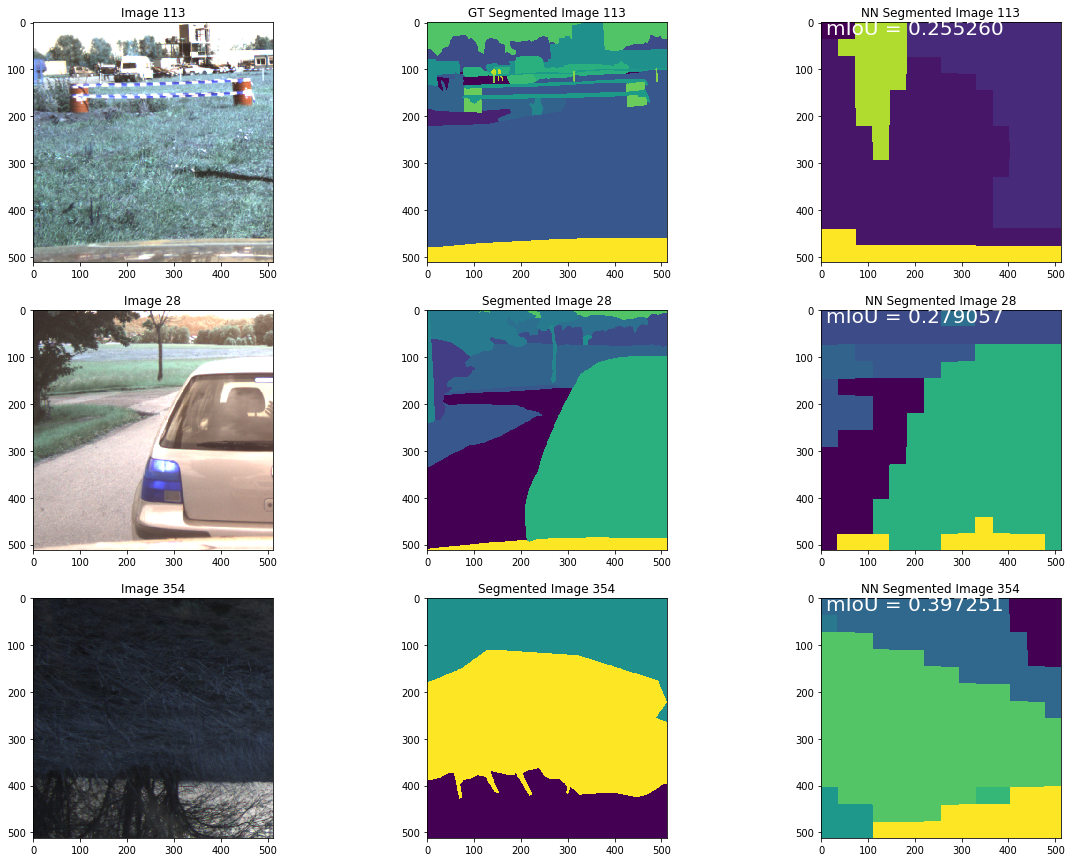

In [20]:
trained_net.eval()

def add_img_txt_plot(fig, index, img, title, sub_plot_id, txt):
    ax = fig.add_subplot(sub_plot_id[0],sub_plot_id[1],sub_plot_id[2])
    plt.title(title + str(index))
    ax.text(10, 25, 'mIoU = {:_>8.6f}'.format(txt), fontsize=20, color='white')
    ax.imshow(img)
    
def get_nn_seg_img(net, data):
    img, get_seg_img = data
    
    nn_seg_output = net.forward(img[None].cuda())
    
    if device != 'cpu':
        nn_seg_img = torch.argmax(nn_seg_output, dim=1).cpu().numpy()[0]
    else:
        nn_seg_img = torch.argmax(nn_seg_output, dim=1).numpy()[0]
        
    gts = get_seg_img.cpu().numpy()
    
    conf = eval_semantic_segmentation(nn_seg_img[None], gts[None])
    
    print("View count of pixels within each label category:")
    print(np.unique(get_seg_img, return_counts=True))
    print(np.unique(nn_seg_img, return_counts=True))
    
    return nn_seg_img, conf['miou']


img_113, seg_img_113 = train_data[113]
img_28, seg_img_28 = train_data[28]
img_354, seg_img_354 = train_data[354]

nn_seg_img_113, miou_113 = get_nn_seg_img(trained_net, train_data[113])
nn_seg_img_28, miou_28 = get_nn_seg_img(trained_net, train_data[28])
nn_seg_img_354, miou_354 = get_nn_seg_img(trained_net, train_data[354])


fig = plt.figure(figsize=(20,15))

add_img_plot(fig, 113, np.rollaxis(img_113.numpy().astype(int), 0, 3), 'Image ', [3,3,1])
add_img_plot(fig, 113, colorize_mask(seg_img_113), 'GT Segmented Image ', [3,3,2])
add_img_txt_plot(fig, 113, colorize_mask_nn_output(nn_seg_img_113), 'NN Segmented Image ', [3,3,3], miou_113)
add_img_plot(fig, 28, np.rollaxis(img_28.numpy().astype(int), 0, 3), 'Image ', [3,3,4])
add_img_plot(fig, 28, colorize_mask(seg_img_28), 'Segmented Image ', [3,3,5])
add_img_txt_plot(fig, 28, colorize_mask_nn_output(nn_seg_img_28), 'NN Segmented Image ', [3,3,6], miou_28)
add_img_plot(fig, 354, np.rollaxis(img_354.numpy().astype(int), 0, 3), 'Image ', [3,3,7])
add_img_plot(fig, 354, colorize_mask(seg_img_354), 'Segmented Image ', [3,3,8])
add_img_txt_plot(fig, 354, colorize_mask_nn_output(nn_seg_img_354), 'NN Segmented Image ', [3,3,9], miou_354)


In [26]:
test_data = DataLoaderSegmentation('test')

View count of pixels within each label category:
(array([ 0,  1,  5,  6,  7, 14], dtype=int64), array([37377, 23011, 43560, 95099, 44373, 18724], dtype=int64))


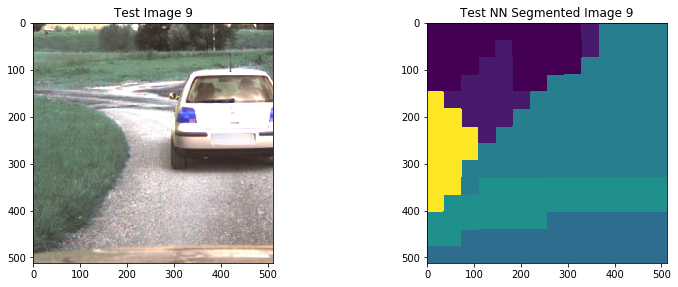

In [31]:
def get_nn_seg_img_test(net, data):
    img = data

    nn_seg_output = net.forward(img[None].cuda())

    if device != 'cpu':
        nn_seg_img = torch.argmax(nn_seg_output, dim=1).cpu().numpy()[0]
    else:
        nn_seg_img = torch.argmax(nn_seg_output, dim=1).numpy()[0]

    print("View count of pixels within each label category:")
    print(np.unique(nn_seg_img, return_counts=True))

    return nn_seg_img

test_img_9 = test_data[9]

test_nn_seg_img_9 = get_nn_seg_img_test(trained_net, test_data[9])

fig = plt.figure(figsize=(20,15))

add_img_plot(fig, 9, np.rollaxis(test_img_9.numpy().astype(int), 0, 3),'Test Image ', [3,3,1])
add_img_plot(fig, 9, colorize_mask_nn_output(test_nn_seg_img_9), 'Test NN Segmented Image ', [3,3,2])

In [32]:
trained_net

Net(
  (mobilenet_v2): MobileNetV2(
    (features): Sequential(
      (0): ConvBNActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1